In [56]:
from datasets import load_dataset
from transformers import AutoTokenizer
from torchvision.io import ImageReadMode, read_image
from transformers.models.bridgetower.modeling_bridgetower import BridgeTowerForContrastiveLearning
from transformers import Trainer, TrainingArguments
from transformers import AutoImageProcessor
import torch
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize
from torchvision.transforms.functional import InterpolationMode, to_grayscale, to_tensor

from optimum.habana import GaudiConfig, GaudiTrainer, GaudiTrainingArguments

import os
# os.environ["ID"] = "0"

# Set up the data

In [57]:
# Load dataset
dset = load_dataset("jmhessel/newyorker_caption_contest", "matching")

Found cached dataset newyorker_caption_contest (/root/.cache/huggingface/datasets/jmhessel___newyorker_caption_contest/matching/1.0.0/43749f7b7c0566b3b1bb518ee81866c0ae27f310ad1b3405918479d6eafcaabe)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 518.73it/s]


In [58]:
# Get the training dataset
train_dataset = dset["train"]

In [59]:
dset["train"]

Dataset({
    features: ['image', 'contest_number', 'image_location', 'image_description', 'image_uncanny_description', 'entities', 'questions', 'caption_choices', 'from_description', 'label', 'n_tokens_label', 'instance_id'],
    num_rows: 9792
})

Two giraffes are in a house. One is on the couch watching TV.


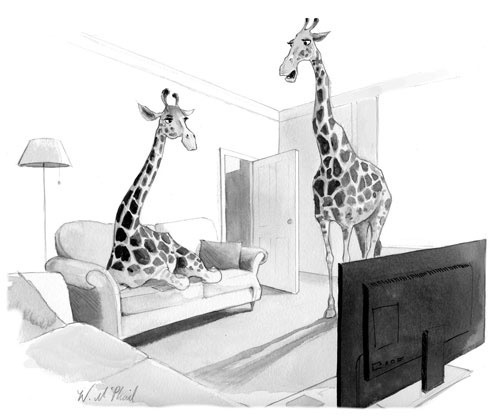

In [60]:
k = 5
print(dset["train"][k]['image_description'])
dset["train"][k]['image']

# Load pre-trained model and tokenizer

In [61]:
# Load pre-trained model and tokenizer
model_name_or_path = "BridgeTower/bridgetower-large-itm-mlm-itc"
model = BridgeTowerForContrastiveLearning.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at BridgeTower/bridgetower-large-itm-mlm-itc were not used when initializing BridgeTowerForContrastiveLearning: ['mlm_score.transform.dense.bias', 'mlm_score.transform.LayerNorm.bias', 'itm_score.fc.bias', 'mlm_score.bias', 'mlm_score.transform.LayerNorm.weight', 'bridgetower.vision_model.visual.class_embedding', 'mlm_score.transform.dense.weight', 'mlm_score.decoder.weight', 'bridgetower.vision_model.visual.positional_embedding', 'bridgetower.vision_model.visual.conv1.weight', 'itm_score.fc.weight']
- This IS expected if you are initializing BridgeTowerForContrastiveLearning from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BridgeTowerForContrastiveLearning from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

# Tokenize the train dataset captions

In [62]:
# Tokenize captions using the tokenizer
def tokenize_captions(examples):
        captions = list(examples["image_description"])
        text_inputs = tokenizer(captions, max_length=128, padding="max_length", truncation=True)
        examples["input_ids"] = text_inputs.input_ids
        examples["attention_mask"] = text_inputs.attention_mask
        return examples

In [63]:
# Tokenize captions of all the train dataset
train_dataset = train_dataset.map(
            function=tokenize_captions,
            batched=True,
            remove_columns=[col for col in dset["train"].column_names if col != "image"],
            num_proc=None,
            desc="Running tokenizer on train dataset",
        )

Loading cached processed dataset at /root/.cache/huggingface/datasets/jmhessel___newyorker_caption_contest/matching/1.0.0/43749f7b7c0566b3b1bb518ee81866c0ae27f310ad1b3405918479d6eafcaabe/cache-3be532a7ffd2812b.arrow


In [64]:
train_dataset

Dataset({
    features: ['image', 'input_ids', 'attention_mask'],
    num_rows: 9792
})

# Image preprocessing

In [65]:
# Convert image to grayscale and tensor
def get_image(image_or_path):
    image_or_path = to_grayscale(image_or_path, num_output_channels=3)
    return to_tensor(image_or_path)

In [66]:
# Preprocess of the image: Resize, CenterCrop, ConvertImageDtype and Normalize
class Transform(torch.nn.Module):
    def __init__(self, image_size, mean, std):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size], interpolation=InterpolationMode.BICUBIC),
            CenterCrop(image_size),
            ConvertImageDtype(torch.float),
            Normalize(mean, std),
        )

    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x

In [67]:
# Load image_processor, in this script we only use this to get the mean and std for normalization.
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)
image_size = model.config.vision_config.image_size

image_transformations = Transform(image_size, image_processor.image_mean, image_processor.image_std)

In [68]:
# Apply image transformations to the images in the examples
def transform_images(examples):
    images = [get_image(image_file) for image_file in examples["image"]]
    examples["pixel_values"] = [image_transformations(image) for image in images]
    return examples

In [69]:
# The transform (image processor) is applied on-the-fly on batches when __getitem__ is called
train_dataset.set_transform(transform_images)

# Training configuration

In [70]:
# The function to use to form a batch from a list of elements of train_dataset
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

In [71]:
# Define training arguments

# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     remove_unused_columns=False,
#     num_train_epochs=1,
#     report_to=[],
#     logging_steps=50
# )

training_args = GaudiTrainingArguments(
    output_dir="test_trainer",
    remove_unused_columns=False,
    use_habana=True,
    use_lazy_mode=True,
    use_hpu_graphs_for_inference=True,
    gaudi_config_name="Habana/clip",
    num_train_epochs=1,
    report_to=[],
    logging_steps=50
)

In [72]:
gaudi_config = GaudiConfig.from_pretrained(training_args.gaudi_config_name)

In [73]:
# Initalize the trainer

# trainer = Trainer(
#         model=model,
#         #gaudi_config=gaudi_config,
#         #args=training_args,
#         args=training_args,
#         train_dataset=train_dataset,
#         data_collator=collate_fn,
#     )

trainer = GaudiTrainer(
    model=model,
    gaudi_config=gaudi_config,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=collate_fn,
)

hmp:verbose_mode  False
hmp:opt_level O1


# Train the model 😃

In [ ]:
# Train the model
train_result = trainer.train(resume_from_checkpoint=None)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Test the model

In [ ]:
ex_1 = train_dataset[0]
# ex_2 = train_dataset[20]


pixel_values_1 = torch.stack([ex_1['pixel_values']]).to('hpu')
input_ids_1 = torch.tensor([ex_1['input_ids']]).to('hpu')
attention_mask_1 = torch.tensor([ex_1['attention_mask']]).to('hpu')

# print(f"pixel_values_1.device: {pixel_values_1.device}")

# pixel_values_2 = torch.stack([ex_1['pixel_values']]).to('hpu')

# print(f"pixel_values_2.device: {pixel_values_2.device}")

encoding_1 = {
    "pixel_values": pixel_values_1,
    "input_ids": input_ids_1,
    "attention_mask": attention_mask_1,
}


outputs_1 = trainer.model(**encoding_1)
logits_text_to_image_1 = torch.matmul(outputs_1['text_embeds'], outputs_1['image_embeds'].t()) 
print(f"logits_text_to_image_1: {logits_text_to_image_1}")

In [ ]:
# logits_text_to_image_1: tensor([[0.3125]], device='hpu:0', dtype=torch.bfloat16, grad_fn=<CppNode<MatmulFunction>>)